Make a copy of this notebook and save it to your drive.

Next, enable this Colab Notebook to run on GPUs by going into `Edit > Notebook Settings > Hardware Accelerator > GPU`.

This tutorial has been adapted from [https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)


Training a Classifier
=====================

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

![](https://pytorch.org/tutorials/_images/cifar10.png)
cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data


(1) Load and normalize CIFAR10
------------------------------

Using ``torchvision``, it’s extremely easy to load CIFAR10.


In [14]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
import time

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [15]:
# First, convert the image to a tensor.
# Second, convert its range from [0,1] to [-1,1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us understand the dataset a bit more:

In [16]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

**Question**: How many batches will `trainloader` use to load the `trainset`?

**Answer:** 50,000/4 = 12,500

Let us show some of the training images, for fun.



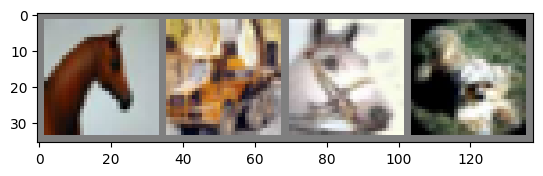

horse truck horse dog  


In [17]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

(2) Define a Convolutional Neural Network
---------

In [18]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 160, 5)
        self.fc1 = nn.Linear(160 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

**Question**: What is the output size of each layer?

**Answer:** The below code prints the output size of each layer. Note that -1 is the indication of flexible batch size

In [19]:
from torchsummary import summary

summary(net, (3, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3          [-1, 160, 10, 10]          24,160
         MaxPool2d-4            [-1, 160, 5, 5]               0
            Linear-5                  [-1, 120]         480,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 515,750
Trainable params: 515,750
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.20
Params size (MB): 1.97
Estimated Total Size (MB): 2.18
----------------------------------------------------------------


(3) Define a Loss function and optimizer
-----------------------
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [20]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

(4) Train the network
--------------------

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the network and optimize. See [here](https://pytorch.org/docs/stable/optim.html#taking-an-optimization-step) for an example of one optimization step.



In [21]:
for epoch in range(2):  # loop over the dataset multiple times

    start_time = time.time()
    running_loss = 0.0
    for i, data in enumerate(trainloader, start=0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

    time_elapsed = time.time() - start_time
    print("Epoch %d: %f secs" % (epoch, time_elapsed))

print('Finished Training')

[1,  2000] loss: 2.065
[1,  4000] loss: 1.728
[1,  6000] loss: 1.532
[1,  8000] loss: 1.451
[1, 10000] loss: 1.392
[1, 12000] loss: 1.346
Epoch 0: 27.696767 secs
[2,  2000] loss: 1.218
[2,  4000] loss: 1.208
[2,  6000] loss: 1.184
[2,  8000] loss: 1.162
[2, 10000] loss: 1.132
[2, 12000] loss: 1.130
Epoch 1: 26.958884 secs
Finished Training


**Question**: Why do we have to zero gradients?

**Answer:** We zero out gradients to overwrite any previous values still present in the gradient.     

    



**Question**: How does `optimizer.step` know which weights to optimize, and by how much?

**Answer:** It updates all parameter values based on the provided gradient of the loss function, and hence is able to alter the weights which minimize loss function.



**Question**: Do you think we've trained until convergence? Why or why not?

**Answer:** No! We have only done 2 epochs and there is still room for much more optimization. We will reach closer to convergence when the changes in error reach to a small value as epochs go on.



Let's quickly save our trained model:



In [22]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html)
for more details on saving PyTorch models.

(5) Test the network on the test data
------------------------------------

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



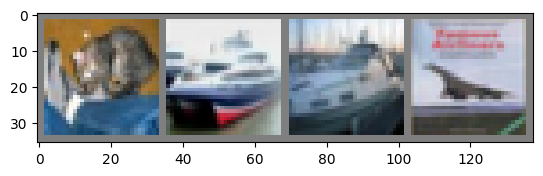

GroundTruth:  cat   ship  ship  plane


In [23]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [24]:
net = Net()
net.load_state_dict(torch.load(PATH))

/var/folders/m1/771scq5n6m914zngx6qzrxc80000gn/T/ipykernel_58399/238682776.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(PATH))


<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:



In [25]:
outputs = net(images)
print(outputs)

tensor([[-1.2635, -2.2830,  1.0767,  3.3815, -0.3514,  2.2967,  1.5932, -0.9068,
         -0.4933, -3.0967],
        [ 5.2677,  5.8516, -1.3268, -2.1546, -3.5312, -4.5939, -3.1647, -5.0465,
          5.7913,  2.3379],
        [ 3.3360,  1.6748,  0.1286, -1.0461, -1.5746, -2.5293, -1.8786, -2.0434,
          2.2916,  0.7487],
        [ 5.5328,  1.1650,  0.3593, -1.5089, -1.6354, -3.8849, -3.1774, -2.9838,
          4.6491, -0.0606]], grad_fn=<AddmmBackward0>)


The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [26]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   car   plane plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [27]:
correct = 0
total = 0
test = []
pred = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test += labels
        pred += predicted

score = correct / total
print(f'Accuracy of the network on the 10000 test images: {100 * score} %')

Accuracy of the network on the 10000 test images: 59.45 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well? Let's visualize the confusion matrix.



In [28]:
from sklearn.metrics import confusion_matrix

def visualize_confusion_matrix(test, pred, score, classes):
    cm = confusion_matrix(test, pred)
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = 'Accuracy Score: {0}'.format(score)
    plt.title(all_sample_title, size = 15)

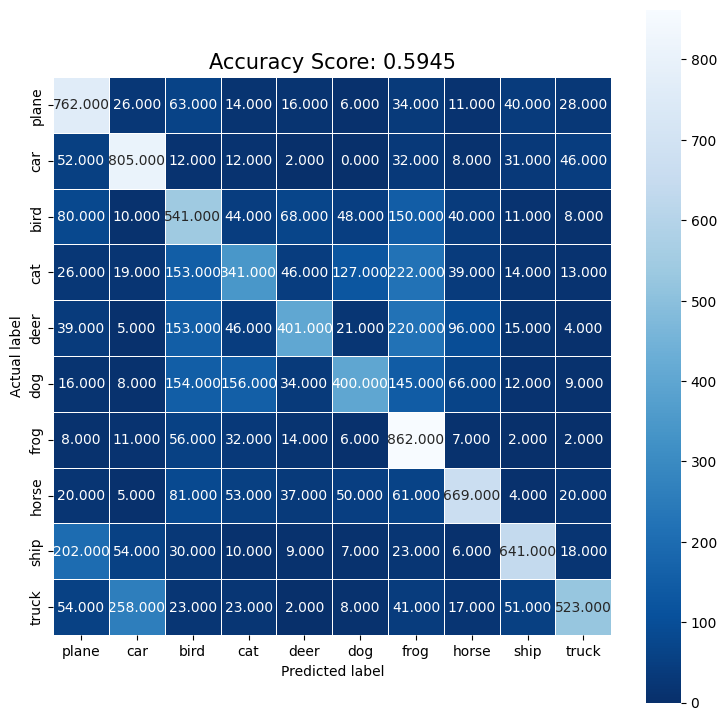

In [29]:
visualize_confusion_matrix(test, pred, score, classes)

**Question**: Do the mistakes make sense? What do you think the network may have learned? How can we determine whether this hunch is true or not?

**Answer:** The network has learned well how to classify vehicles. But it has not learned to classify cats, dogs and deers well. We can check the model's class-wise test accuracy to check that. As you can see below, the model is doing fine with vehicles but not as good with animals and birds.

Oftentimes, to understand a network's performance, multiple views of the data is helpful. Let's look at the numeric performance per class.

In [30]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 76.2 %
Accuracy for class: car   is 80.5 %
Accuracy for class: bird  is 54.1 %
Accuracy for class: cat   is 34.1 %
Accuracy for class: deer  is 40.1 %
Accuracy for class: dog   is 40.0 %
Accuracy for class: frog  is 86.2 %
Accuracy for class: horse is 66.9 %
Accuracy for class: ship  is 64.1 %
Accuracy for class: truck is 52.3 %


Okay, so what next?

How do we run these neural networks on the GPU?

Training on GPU
----------------
Let's define our device as the first visible cuda device if we have CUDA available:



In [31]:
device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

mps:0


The rest of this section assumes that ``device`` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:




Now let us rerun training. Note that you have to send the inputs and targets at every step to the GPU as well.

In [32]:
net = Net()
net.to(device) # Move the network to the GPU

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(2):  # loop over the dataset multiple times

    start_time = time.time()
    running_loss = 0.0
    for i, data in enumerate(trainloader, start=0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

    time_elapsed = time.time() - start_time
    print("Epoch %d: %f secs" % (epoch, time_elapsed))

print('Finished Training')

[1,  2000] loss: 2.069
[1,  4000] loss: 1.701
[1,  6000] loss: 1.543
[1,  8000] loss: 1.451
[1, 10000] loss: 1.370
[1, 12000] loss: 1.328
Epoch 0: 57.080126 secs
[2,  2000] loss: 1.212
[2,  4000] loss: 1.175
[2,  6000] loss: 1.170
[2,  8000] loss: 1.130
[2, 10000] loss: 1.115
[2, 12000] loss: 1.122
Epoch 1: 54.435773 secs
Finished Training


**Question**: Why isn't there a big difference in runtime? What would we have to change to see a big(ger) difference in runtime?

**Answer:** There is not a big difference in runtime because GPU is optimized for high load and parallelized workloads. The model we trained was simple and had less data to process. Thus, CPU did better as GPU took marginally more time, most probably due to the overhead of the python to C/C++ code for CUDA.
_________

Make the change to the network. Divide up the class in two. Have half the people run the new network on the CPU, and the other half on the GPU. Do you see a difference in runtime?

Suggested change: by altering the number of parameters in conv2 -> fc1 layer:

`self.conv2 = nn.Conv2d(6, 160, 5)`

 `self.fc1 = nn.Linear(160 * 5 * 5, 120)`


